# Meal Demand Forecasting

Background:
The client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. 

__Objective:__ predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:
- Historical data of demand for a product-center combination (Weeks: 1 to 145)
- Product(Meal) features such as category, sub-category, current price and discount
- Information for fulfillment center like center area, city information etc.

Data:
https://www.kaggle.com/sureshmecad/meal-demand-forecasting

In [30]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Import datasets

### Product (Meal) categories

In [31]:
#load Product features
meal_info = pd.read_csv("../input/food-demand-forecasting/meal_info.csv")
print(meal_info.shape)
meal_info.head()

(51, 3)


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [32]:
#verify no null values
meal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


### Fulfillment center information

In [33]:
fulfilment_center = pd.read_csv('../input/food-demand-forecasting/fulfilment_center_info.csv')
print(fulfilment_center.shape)
fulfilment_center.head()

(77, 5)


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [34]:
fulfilment_center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


### Product demand historical data

In [35]:
#import train set
raw_train = pd.read_csv('../input/food-demand-forecasting/train.csv')
print(raw_train.shape)
raw_train.head()

(456548, 9)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [36]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [37]:
raw_test = pd.read_csv('../input/food-demand-forecasting/test.csv')
print(raw_test.shape)
raw_test.head()

(32573, 8)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [38]:
raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32573 non-null  int64  
 1   week                   32573 non-null  int64  
 2   center_id              32573 non-null  int64  
 3   meal_id                32573 non-null  int64  
 4   checkout_price         32573 non-null  float64
 5   base_price             32573 non-null  float64
 6   emailer_for_promotion  32573 non-null  int64  
 7   homepage_featured      32573 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


## Data Wrangling

Merge information from the relational tables usind the IDs to obtain Train/Test datasets with the features needed for the multivariate model. Handle any missing/incorrect values.
Any data type errors are corrected. Some Features of numeric type(city_code, region_code) are treated as categorical variables, as they represent a location.

In [39]:
# Merge datasets based on ID features
test = pd.merge(left = raw_test, right = fulfilment_center, left_on = 'center_id', right_on = 'center_id', how='left')
test = pd.merge(left = test, right = meal_info, left_on = 'meal_id', right_on = 'meal_id', how = 'left')

#change type of incorrectly classified features
#test[['city_code','region_code']] = test[['city_code','region_code']].astype('object')
#test.set_index('id', inplace=True)

print(test.shape)
test.head()

(32573, 14)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
1,1127204,146,55,1993,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
2,1212707,146,55,2539,157.14,159.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai
3,1082698,146,55,2631,162.02,162.02,0,0,647,56,TYPE_C,2.0,Beverages,Indian
4,1400926,146,55,1248,163.93,163.93,0,0,647,56,TYPE_C,2.0,Beverages,Indian


In [40]:
# Merge datasets based on ID features
train = pd.merge(left = raw_train, right = fulfilment_center, left_on = 'center_id', right_on = 'center_id', how='left')
train = pd.merge(left = train, right = meal_info, left_on = 'meal_id', right_on = 'meal_id', how = 'left')

#change type of incorrectly classified features
#train[['city_code','region_code']] = train[['city_code','region_code']].astype('object')
#train.set_index('id', inplace=True)

print(train.shape)
train.head()

(456548, 15)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [41]:
append = test.append(train)
append.shape

(489121, 15)

## Explore data

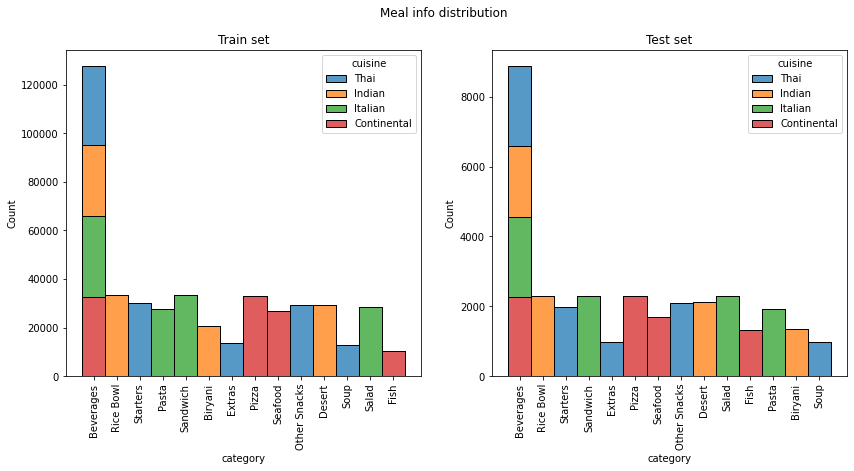

In [42]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
fig.suptitle('Meal info distribution')
sns.histplot(ax = ax[0], data=train[['category','cuisine']],x='category', hue='cuisine', multiple='stack').set_title("Train set")
sns.histplot(ax = ax[1], data=test[['category','cuisine']],x='category', hue='cuisine', multiple='stack').set_title("Test set")

for ax in ax:
    ax.tick_params(axis='x', labelrotation=90)
plt.show()

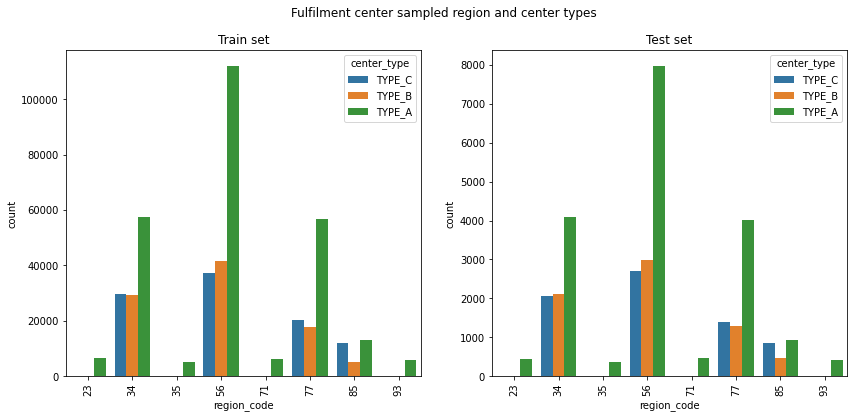

In [43]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
fig.suptitle('Fulfilment center sampled region and center types')
sns.countplot(ax = ax[0], data=train[['region_code','center_type']],x='region_code', hue='center_type').set_title("Train set")
sns.countplot(ax = ax[1], data=test[['region_code','center_type']],x='region_code', hue='center_type').set_title("Test set")

for ax in ax:
    ax.tick_params(axis='x', labelrotation=90)
plt.show()

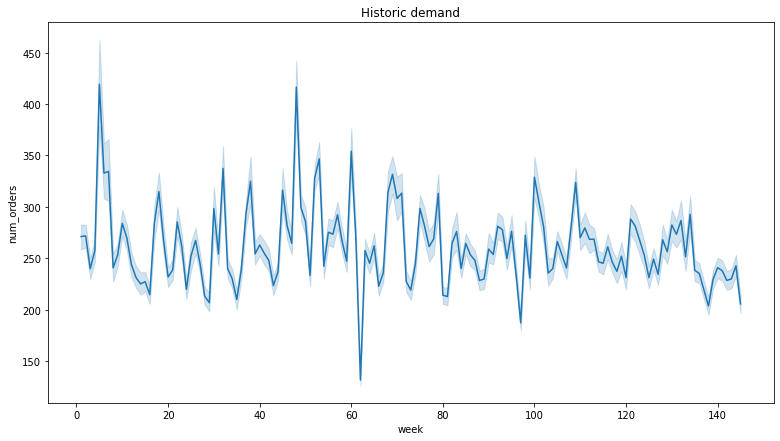

In [44]:
plt.figure(figsize=(13,7))
sns.lineplot(data=append, x='week', y='num_orders').set_title('Historic demand')
plt.show()

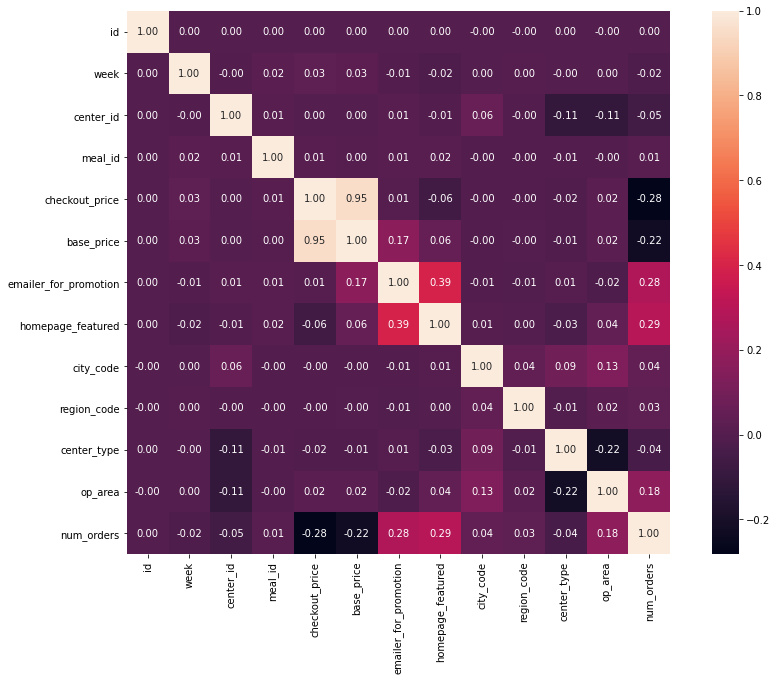

In [76]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
append['center_type'] = le.fit_transform(append['center_type'])
plt.figure(figsize=(15,10))
sns.heatmap(append.corr(), cbar=True, annot=True, square=True, fmt='.2f')
plt.show()

Observing the linear correlation heatmap, it is clear that the operation area (size in m2), pries, as well as promotions, have the largest impact on the number of orders.

## Model Development
- One hot encoding for categorical variables
- Normalization
- Model computing

In [63]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics 

In [45]:
train

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,473,77,TYPE_A,4.5,Desert,Indian
456544,1062036,145,61,2304,482.09,482.09,0,0,42,473,77,TYPE_A,4.5,Desert,Indian
456545,1110849,145,61,2664,237.68,321.07,0,0,501,473,77,TYPE_A,4.5,Salad,Italian
456546,1147725,145,61,2569,243.50,313.34,0,0,729,473,77,TYPE_A,4.5,Salad,Italian


### One hot encoding

In [46]:
features_to_encode = ['center_type', 'category', 'cuisine']

def one_hot_encode(features_to_encode, dataset):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(dataset[features_to_encode])

    encoded_cols = pd.DataFrame(encoder.transform(dataset[features_to_encode]),columns=encoder.get_feature_names())
    dataset = dataset.drop(columns=features_to_encode)
    for cols in encoded_cols.columns:
        dataset[cols] = encoded_cols[cols]
    return dataset

In [47]:
OH_train = one_hot_encode(features_to_encode, train)
OH_train.set_index('id', inplace=True)
OH_train_y = OH_train['num_orders']
OH_train_X = OH_train.drop(columns='num_orders')
OH_train

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,...,x1_Rice Bowl,x1_Salad,x1_Sandwich,x1_Seafood,x1_Soup,x1_Starters,x2_Continental,x2_Indian,x2_Italian,x2_Thai
id,,,,,,,,,,,,,,,,,,,,,
1379560,1,55,1885,136.83,152.29,0,0,177,647,56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1466964,1,55,1993,136.83,135.83,0,0,270,647,56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1346989,1,55,2539,134.86,135.86,0,0,189,647,56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1338232,1,55,2139,339.50,437.53,0,0,54,647,56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1448490,1,55,2631,243.50,242.50,0,0,40,647,56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271326,145,61,1543,484.09,484.09,0,0,68,473,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1062036,145,61,2304,482.09,482.09,0,0,42,473,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1110849,145,61,2664,237.68,321.07,0,0,501,473,77,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [91]:
OH_test = one_hot_encode(features_to_encode, test)
OH_test.set_index('id', inplace=True)
OH_test

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,op_area,...,x1_Rice Bowl,x1_Salad,x1_Sandwich,x1_Seafood,x1_Soup,x1_Starters,x2_Continental,x2_Indian,x2_Italian,x2_Thai
id,,,,,,,,,,,,,,,,,,,,,
1028232,146,55,1885,158.11,159.11,0,0,647,56,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1127204,146,55,1993,160.11,159.11,0,0,647,56,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1212707,146,55,2539,157.14,159.14,0,0,647,56,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1082698,146,55,2631,162.02,162.02,0,0,647,56,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1400926,146,55,1248,163.93,163.93,0,0,647,56,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250239,155,61,1543,482.09,484.09,0,0,473,77,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1039516,155,61,2304,483.09,483.09,0,0,473,77,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1158107,155,61,2664,322.07,323.07,0,0,473,77,4.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(OH_train_X, OH_train_y, test_size = 0.30)

### Ensemble Model: RandomForestRegressor

In [77]:
RF_pipe = make_pipeline(StandardScaler(),RandomForestRegressor())
RF_pipe.fit(X_train, y_train)
RF_train_y_pred = RF_pipe.predict(X_val)
print(RF_pipe.score(X_val, y_val))
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(y_val, RF_train_y_pred)))

0.8496364680983732
RMSLE: 49.14962232833383


### Linear Models: Stochastic Gradient Descent

In [61]:
# make pipeline
SGD_pipe = make_pipeline(StandardScaler(),SGDRegressor())
SGD_pipe.fit(X_train, y_train)
SGD_train_y_pred = SGD_pipe.predict(X_val)
print(SGD_pipe.score(X_val, y_val))
#print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(y_val, SGD_train_y_pred)))

0.4006012157319665


### Decision Tree: Regressor

In [64]:
DT_pipe = make_pipeline(StandardScaler(),DecisionTreeRegressor())
DT_pipe.fit(X_train, y_train)
DT_train_y_pred = DT_pipe.predict(X_val)
print(DT_pipe.score(X_val, y_val))
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(y_val, DT_train_y_pred)))

0.7351671666533268
RMSLE: 64.3595045668994


### Tune hyperparameters for best fitting model. Cross Validate.
Tune hyperparameters on best fitting model through cross validation. Fit to whole training dataset. 

In [78]:
for keys in RF_pipe.get_params().items():
    print(keys[0],": ",keys[1])

memory :  None
steps :  [('standardscaler', StandardScaler()), ('randomforestregressor', RandomForestRegressor())]
verbose :  False
standardscaler :  StandardScaler()
randomforestregressor :  RandomForestRegressor()
standardscaler__copy :  True
standardscaler__with_mean :  True
standardscaler__with_std :  True
randomforestregressor__bootstrap :  True
randomforestregressor__ccp_alpha :  0.0
randomforestregressor__criterion :  mse
randomforestregressor__max_depth :  None
randomforestregressor__max_features :  auto
randomforestregressor__max_leaf_nodes :  None
randomforestregressor__max_samples :  None
randomforestregressor__min_impurity_decrease :  0.0
randomforestregressor__min_impurity_split :  None
randomforestregressor__min_samples_leaf :  1
randomforestregressor__min_samples_split :  2
randomforestregressor__min_weight_fraction_leaf :  0.0
randomforestregressor__n_estimators :  100
randomforestregressor__n_jobs :  None
randomforestregressor__oob_score :  False
randomforestregressor_

In [101]:
hyperparameters = {'randomforestregressor__max_features' : ['auto','log2'],
                  'randomforestregressor__max_depth' : [None]}

RF_grid_search = GridSearchCV(RF_pipe, hyperparameters, cv=2, verbose=1)

#Fit and tune model
RF_grid_search.fit(OH_train_X, OH_train_y)
print (RF_grid_search.best_params_)
print (RF_grid_search.refit)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


KeyboardInterrupt: 

### Forecast test data with trained, optimized model

In [99]:
OH_test_y_pred = RF_grid_search.predict(OH_test)

submission = pd.DataFrame(data=OH_test_y_pred, index=OH_test.index, columns = ['num_orders'])
submission.reset_index(inplace=True)
submission.to_csv('./submission.csv')
submission

,id,num_orders
0,1028232,112.26
1,1127204,81.45
2,1212707,133.12
3,1082698,74.72
4,1400926,69.80
...,...,...
32568,1250239,75.41
32569,1039516,23.41
32570,1158107,389.21
32571,1444235,356.92
